# Feature Selection


Feature Selection ist ein entscheidender Prozess in der Modellentwicklung, bei dem gezielt ein Subset der relevantesten Merkmale (Features) aus dem gesamten Datensatz ausgewählt wird. Das Ziel ist es, die Modellleistung zu verbessern, indem irrelevante oder redundante Features entfernt werden. Dies reduziert das Risiko von Overfitting, verkürzt die Trainingszeiten und führt oft zu einfacheren und besser interpretierbaren Modellen.

#### Finale Dataframes erstellen

Basierend auf den Prinzipien des Feature Engineerings und der Dimensionsreduktion wurden in diesem Schritt mehrere finale Daten-Versionen (DataFrames) für die nachfolgende Modellevaluierung erstellt. Jeder dieser DataFrames repräsentiert eine andere Strategie im Umgang mit den Features, um die bestmögliche Datengrundlage zu finden:

* **Full-DataFrame:** Enthält den vollständigen, aufbereiteten Satz an Features als Referenzpunkt.
* **Feature-Selection-DataFrame:** Enthält ein Subset der Features, das durch Selektionsmethoden als relevant identifiziert wurde.
* **PCA-DataFrame:** Nutzt die Hauptkomponentenanalyse (PCA), um die Dimensionalität zu reduzieren und die Informationen in weniger, unkorrelierten Features zu komprimieren. Hier werden die Features beibehalten, welche in den Komponenten vorkommen, welche die 95% der Varianz erklären.
* **Reduced-DataFrame:** Repräsentiert eine Mischung aus der Feature Selektion und den PCA Features.

In [48]:
import pandas as pd
from pathlib import Path  
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SequentialFeatureSelector, RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
import re
import matplotlib.pyplot as plt
from collections import Counter
# --- Imports ---
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.impute import SimpleImputer


Dieser Code-Abschnitt lädt den final aufbereiteten DataFrames aus den Pickle-Dateien `df_Regression.pkl` und `df_Classification.pkl`. Da beim Speichern und Laden von Daten die spezifischen Datentypen verloren gehen können (z.B. werden aus Zahlen `object`-Typen), wird anschließend ein robuster Konvertierungsprozess durchgeführt.

Zuerst identifiziert und "schützt" der Code alle Spalten, die bereits ein korrektes `datetime`-Format haben. Danach optimiert die Funktion `df.convert_dtypes()` alle anderen Spalten automatisch in den bestmöglichen, speichereffizienten Datentyp. 

Die Funktion `df.convert_dtypes()` ist eine intelligente Methode in Pandas, um die Datentypen eines DataFrames automatisch zu optimieren und in das bestmögliche, speichereffizienteste Format umzuwandeln.

**Was im Detail passiert:**


* Eine `object`-Spalte, die nur Zahlen enthält (z.B. `['1', '2', '3']`), wird in einen numerischen Typ umgewandelt.
* Eine `object`-Spalte, die nur Text enthält, wird in den modernen `string`-Typ umgewandelt, der für Textoperationen optimiert ist.
* Eine `float64`-Spalte, die nur Ganzzahlen enthält (z.B. `[1.0, 2.0, 3.0]`), wird in einen Integer-Typ umgewandelt.

In [49]:
import pandas as pd
from pathlib import Path
import os # Wird nicht direkt benötigt, aber hilfreich

# Pfade definieren
this_dir = Path.cwd()
data_dir = this_dir / ".." / "Data"
data_dir = data_dir.resolve()

# --- Hilfsfunktion zum Laden und Konvertieren ---
def load_and_convert_df(df_name: str) -> pd.DataFrame:
    """Lädt einen DataFrame, konvertiert seine Typen und gibt ihn zurück."""
    
    pkl_path = data_dir / f"{df_name}.pkl"
    df = None
    
    print("=" * 70)
    print(f"--- BEARBEITE DATAFRAME: {df_name} ---")
    
    try:
        # 1. Pickle-Datei laden
        df = pd.read_pickle(pkl_path)
        print(f"DataFrame '{df_name}' erfolgreich geladen. Datentypen VOR der Konvertierung:")
        df.info(verbose=False)

        # 2. Datentypen intelligent konvertieren
        print("\nStarte automatische Konvertierung der Datentypen...")
        
        # a) Merke dir, welche Spalten bereits datetime sind
        datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
        if not datetime_cols.empty:
            print(f"  - Folgende Datetime-Spalten werden geschützt: {list(datetime_cols)}")

        # b) Führe die allgemeine, automatische Konvertierung durch
        df = df.convert_dtypes()
        
        # Stelle sicher, dass die datetime-Spalten ihren Typ behalten haben
        for col in datetime_cols:
            df[col] = pd.to_datetime(df[col], errors='coerce')

        print("Konvertierung abgeschlossen.")

        # 3. Ergebnis überprüfen
        print(f"\nDatentypen NACH der Konvertierung von '{df_name}':")
        df.info(verbose=False)
        
        return df

    except FileNotFoundError:
        print(f"FEHLER: Die Datei '{pkl_path.name}' wurde nicht im Verzeichnis '{pkl_path.parent}' gefunden.")
        return None
    except Exception as e:
        print(f"Ein unerwarteter Fehler beim Laden/Konvertieren von '{df_name}' ist aufgetreten: {e}")
        return None

# --- Ausführung für beide DataFrames ---

# 1. Regression DataFrame
df_Regression = load_and_convert_df("df_Regression")

# 2. Klassifikation DataFrame
df_Classification = load_and_convert_df("df_Classification")

print("\n" + "="*70)
if df_Regression is not None and df_Classification is not None:
    print("Beide DataFrames (df_Regression und df_Classification) wurden erfolgreich geladen und konvertiert.")
else:
    print("ACHTUNG: Mindestens ein DataFrame konnte nicht geladen oder konvertiert werden.")

--- BEARBEITE DATAFRAME: df_Regression ---
DataFrame 'df_Regression' erfolgreich geladen. Datentypen VOR der Konvertierung:
<class 'pandas.core.frame.DataFrame'>
Index: 50329 entries, 0 to 50328
Columns: 15 entries, oh__PSP_Goldcard to bin__daytime_Nachmittag
dtypes: Float64(3), Int32(3), Int64(9)
memory usage: 6.3 MB

Starte automatische Konvertierung der Datentypen...
Konvertierung abgeschlossen.

Datentypen NACH der Konvertierung von 'df_Regression':
<class 'pandas.core.frame.DataFrame'>
Index: 50329 entries, 0 to 50328
Columns: 15 entries, oh__PSP_Goldcard to bin__daytime_Nachmittag
dtypes: Float64(3), Int32(3), Int64(9)
memory usage: 6.3 MB
--- BEARBEITE DATAFRAME: df_Classification ---
DataFrame 'df_Classification' erfolgreich geladen. Datentypen VOR der Konvertierung:
<class 'pandas.core.frame.DataFrame'>
Index: 50329 entries, 0 to 50328
Columns: 15 entries, oh__PSP_Goldcard to bin__daytime_Nachmittag
dtypes: Float64(2), Int32(3), Int64(10)
memory usage: 6.3 MB

Starte automatis

In [50]:
# Spalten entfernen (Duplikate werden automatisch ignoriert, aber die Liste ist jetzt sauber)
df_Regression.drop(columns="bin__success", inplace=True, errors='ignore')
df_Regression.columns

# Spalten entfernen (Duplikate werden automatisch ignoriert, aber die Liste ist jetzt sauber)
df_Classification.drop(columns="remainder__fee", inplace=True, errors='ignore')
df_Classification.columns

Index(['oh__PSP_Goldcard', 'oh__PSP_Moneycard', 'oh__PSP_Simplecard',
       'oh__PSP_UK_Card', 'oh__card_Diners', 'oh__card_Master',
       'oh__card_Visa', 'bin__success', 'bin__3D_secured', 'ord__amount_cat',
       'remainder__hour_sin', 'remainder__amount_scaled', 'monatsanfang',
       'bin__daytime_Nacht', 'bin__daytime_Nachmittag'],
      dtype='object')

# Klassifikation

### PCA

90 % Varianz → 9 Komponenten
95 % Varianz → 10 Komponenten


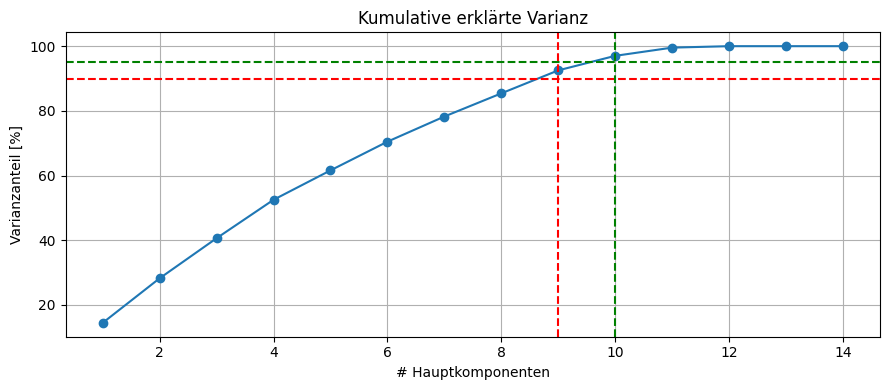


PCA-DataFrame (95 % Varianz):
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.704223 -1.237174 -1.658437  1.251780 -1.394596  0.346860 -0.219022   
1  1.704223 -1.237174 -1.658437  1.251780 -1.394596  0.346860 -0.219022   
2  0.963657  0.971547 -1.395044  1.074701  1.924024 -1.035704 -0.188173   
3  0.963657  0.971547 -1.395044  1.074701  1.924024 -1.035704 -0.188173   
4  1.539916 -1.198632 -1.324761 -1.604098  1.277342 -2.081155 -0.500212   

        PC8       PC9      PC10  
0  1.180233  1.901103  0.719485  
1  1.180233  1.901103  0.719485  
2  2.614018  0.288462  0.745426  
3  2.614018  0.288462  0.745426  
4  0.915486  1.901886  0.693232  


In [51]:
# Feature-Matrix
X = df_Classification.drop(columns=["bin__success"])
y = df_Classification["bin__success"].astype(int)

# numerische / kategoriale Spalten
num_cols = X.select_dtypes(include=["number"]).columns
cat_cols = X.columns.difference(num_cols)

# Vorverarbeitung
preproc = ColumnTransformer(
    [
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler",  StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe",     OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols)
    ],
    remainder="drop"
)

# PCA
pca = PCA(n_components=None, random_state=42)
pipe = Pipeline([("prep", preproc), ("pca", pca)]).fit(X)

evr     = pipe.named_steps["pca"].explained_variance_ratio_
cum_evr = np.cumsum(evr)
k90 = np.argmax(cum_evr >= 0.90) + 1
k95 = np.argmax(cum_evr >= 0.95) + 1
print(f"90 % Varianz → {k90} Komponenten")
print(f"95 % Varianz → {k95} Komponenten")

# Scree-Plot
plt.figure(figsize=(9, 4))
plt.plot(range(1, len(evr)+1), cum_evr*100, marker="o")
plt.axhline(90, color="red", ls="--");  plt.axvline(k90, color="red", ls="--")
plt.axhline(95, color="green", ls="--"); plt.axvline(k95, color="green", ls="--")
plt.title("Kumulative erklärte Varianz")
plt.xlabel("# Hauptkomponenten"); plt.ylabel("Varianzanteil [%]")
plt.grid(True); plt.tight_layout(); plt.show()

# Transformieren & als DataFrame (95 %)
X_pca  = pipe.transform(X)[:, :k95]
pc_cols = [f"PC{i+1}" for i in range(k95)]
df_Classification_pca  = pd.DataFrame(X_pca, columns=pc_cols, index=X.index)
print("\nPCA-DataFrame (95 % Varianz):")
print(df_Classification_pca.head())


In [52]:
# Feature-Namen nach Preprocessing holen
feat_names = pipe.named_steps["prep"].get_feature_names_out()

# PCA-Komponentenmatrix
components = pipe.named_steps["pca"].components_   # shape: (n_components, n_features)

# DataFrame: Komponenten × Features
loadings = pd.DataFrame(components.T, index=feat_names,
                        columns=[f"PC{i+1}" for i in range(components.shape[0])])

# Für jede Komponente Top-Features ausgeben
top_n = 5  # Anzahl der wichtigsten Features pro Komponente
for pc in loadings.columns[:k95]:   # nur die PCs, die 95 % Varianz erklären
    top_feats = loadings[pc].abs().sort_values(ascending=False).head(top_n)
    print(f"\n{pc} – wichtigste Features:")
    for feat, val in top_feats.items():
        print(f"{feat:40s} | Ladung {val:.3f}")



PC1 – wichtigste Features:
num__remainder__hour_sin                 | Ladung 0.594
num__bin__daytime_Nachmittag             | Ladung 0.530
num__bin__daytime_Nacht                  | Ladung 0.525
num__ord__amount_cat                     | Ladung 0.212
num__remainder__amount_scaled            | Ladung 0.211

PC2 – wichtigste Features:
num__remainder__amount_scaled            | Ladung 0.674
num__ord__amount_cat                     | Ladung 0.673
num__remainder__hour_sin                 | Ladung 0.186
num__bin__daytime_Nachmittag             | Ladung 0.174
num__bin__daytime_Nacht                  | Ladung 0.151

PC3 – wichtigste Features:
num__oh__card_Master                     | Ladung 0.757
num__oh__card_Visa                       | Ladung 0.511
num__oh__card_Diners                     | Ladung 0.402
num__oh__PSP_Simplecard                  | Ladung 0.036
num__bin__daytime_Nachmittag             | Ladung 0.028

PC4 – wichtigste Features:
num__oh__PSP_UK_Card                     | Ladun

In [53]:
top_n = 5  # wie viele Top-Features je PC berücksichtigen

records = []
pcs = loadings.columns[:k95]  # nur PCs bis 95% Varianz

for pc in pcs:
    top_feats = loadings[pc].abs().sort_values(ascending=False).head(top_n)
    for feat, val in top_feats.items():
        records.append({"feature": feat, "pc": pc, "abs_loading": float(val)})

# Aggregation: Summe der Ladungen und Anzahl der Vorkommen je Feature
agg = (pd.DataFrame(records)
         .groupby("feature", as_index=False)
         .agg(sum_abs_loading=("abs_loading", "sum"),
              count=("abs_loading", "size")))

# Optional: max-Ladung und PC der max-Ladung (hilfreich zur Einordnung)
max_info = (pd.DataFrame(records)
              .sort_values(["feature", "abs_loading"], ascending=[True, False])
              .groupby("feature", as_index=False)
              .first()[["feature", "pc", "abs_loading"]]
              .rename(columns={"pc": "pc_max", "abs_loading": "max_abs_loading"}))

result = (agg.merge(max_info, on="feature", how="left")
             .sort_values(["sum_abs_loading", "count"], ascending=[False, False])
             .reset_index(drop=True))

# Ausgabe
print(result.head(20))          # Top 20


                          feature  sum_abs_loading  count pc_max  \
0          num__oh__PSP_Moneycard         1.628568      5    PC6   
1         num__oh__PSP_Simplecard         1.590742      7    PC6   
2            num__bin__3D_secured         1.464230      3    PC8   
3               num__monatsanfang         1.455875      3    PC9   
4            num__oh__card_Diners         1.445963      4    PC5   
5              num__oh__card_Visa         1.414043      4    PC5   
6    num__bin__daytime_Nachmittag         1.411493      4   PC10   
7         num__bin__daytime_Nacht         1.409287      3   PC10   
8           num__oh__PSP_Goldcard         1.251451      5    PC7   
9   num__remainder__amount_scaled         0.918755      3    PC2   
10           num__ord__amount_cat         0.885079      2    PC2   
11           num__oh__PSP_UK_Card         0.858410      3    PC4   
12       num__remainder__hour_sin         0.815315      3    PC1   
13           num__oh__card_Master         0.7569

In [54]:
target = "bin__success"

# 1) PSP-Mussliste
psp_required = [
    "oh__PSP_Goldcard", "oh__PSP_Moneycard",
    "oh__PSP_Simplecard", "oh__PSP_UK_Card"
]

missing_psp = [c for c in psp_required if c not in df_Classification.columns]
if missing_psp:
    raise ValueError(f"Fehlende PSP-Spalten: {missing_psp}. "
                     "Alle PSPs müssen im Trainingsdatensatz vorhanden sein.")

if target not in df_Classification.columns:
    raise ValueError(f"Zielspalte fehlt: {target}")

# 2) Top-Features aus result
selected_features = result["feature"].head(18).tolist()

def strip_prefix(name: str) -> str:
    return re.sub(r'^(num|cat)__', '', name)

orig_names = [strip_prefix(f) for f in selected_features]

# 3) Nur existierende Features übernehmen
present = [c for c in orig_names if c in df_Classification.columns]

# 4) Union in stabiler Reihenfolge: ausgewählte + PSP + Target
def uniq(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

cols_final_pca = uniq(present + psp_required + [target])

# 5) Subset
df_classification_pca_original_features = df_Classification[cols_final_pca].copy()

print("Gewählte Spalten:", cols_final_pca)
print("Shape:", df_classification_pca_original_features.shape)


Gewählte Spalten: ['oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'bin__3D_secured', 'monatsanfang', 'oh__card_Diners', 'oh__card_Visa', 'bin__daytime_Nachmittag', 'bin__daytime_Nacht', 'oh__PSP_Goldcard', 'remainder__amount_scaled', 'ord__amount_cat', 'oh__PSP_UK_Card', 'remainder__hour_sin', 'oh__card_Master', 'bin__success']
Shape: (50329, 15)



- Die finale Auswahl der 16 Spalten nach PCA und Korrelationsanalyse umfasst die PSP- und Kartentypen als strukturelle Basisfaktoren, ergänzt durch kritische binäre Indikatoren wie 3D-Secure, Monatsanfang und die Tageszeit-Hotspots (Nacht/Nachmittag), sowie die skalierte und kategorisierte Betragsinformation, um die Vorhersage des Transaktionserfolgs (bin__success) zu optimieren.

### Feature Selection

In [55]:
#  Vorgaben
target = "bin__success"
psp_required = ["oh__PSP_Goldcard", "oh__PSP_Moneycard", "oh__PSP_Simplecard", "oh__PSP_UK_Card"]
k = 5  # Anzahl zu wählender Features je Selektionsmethode

if target not in df_Classification.columns:
    raise ValueError(f"Zielspalte fehlt: {target}")

# X/y und Split
X = df_Classification.drop(columns=[target])
y = df_Classification[target].astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature-Selection Pipelines
pipelines = {
    "KBest (MI)": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("sel", SelectKBest(mutual_info_classif, k=k))
    ]),
    "SFS-GNB": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("sel", SequentialFeatureSelector(
            GaussianNB(), n_features_to_select=k,
            direction="forward", scoring="accuracy", cv=5, n_jobs=-1))
    ]),
    "SFS-DTC": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("sel", SequentialFeatureSelector(
            DecisionTreeClassifier(max_depth=5, random_state=42),
            n_features_to_select=k,
            direction="forward", scoring="accuracy", cv=5, n_jobs=-1))
    ]),
    "RFE-SGD": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("sel", RFE(
            SGDClassifier(loss="log_loss", max_iter=1000, random_state=42),
            n_features_to_select=k, step=0.1))
    ]),
    "RFE-DTC": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("sel", RFE(
            DecisionTreeClassifier(max_depth=5, random_state=42),
            n_features_to_select=k, step=0.1))
    ])
}

# Feature-Selektionen ausführen
selections = {}
for name, pipe in pipelines.items():
    pipe.fit(X_tr, y_tr)
    mask = pipe.named_steps["sel"].get_support()
    feats = [f for f, keep in zip(X.columns, mask) if keep]
    selections[name] = feats
    print(f"\n{name} | {len(feats)} Features")
    print(", ".join(feats))

# Union in Originalspalten-Reihenfolge
def stable_union_in_df_order(df_cols, lists_of_cols):
    seen = set()
    out = []
    for c in df_cols:
        if any(c in L for L in lists_of_cols) and c not in seen:
            seen.add(c)
            out.append(c)
    return out

all_selected_features = stable_union_in_df_order(X.columns, selections.values())
print("\nUnion der gewählten Features:")
print(all_selected_features)

# PSP + Target erzwingen
psp_in_df = [c for c in psp_required if c in df_Classification.columns]
missing_psp = [c for c in psp_required if c not in df_Classification.columns]
if missing_psp:
    print("Warnung: Fehlende PSP-Spalten im DataFrame:", missing_psp)

cols_final_fs = all_selected_features[:]

# PSP-Spalten am Ende in DF-Order ergänzen, falls nicht enthalten
for c in X.columns:  # respektiert Originalreihenfolge
    if c in psp_in_df and c not in cols_final_fs:
        cols_final_fs.append(c)

# Target ergänzen
if target not in cols_final_fs:
    cols_final_fs.append(target)

print("\nGesamtliste inkl. erzwungener PSPs + Target:")
print(cols_final_fs)



KBest (MI) | 5 Features
oh__PSP_Goldcard, oh__card_Master, bin__3D_secured, ord__amount_cat, bin__daytime_Nachmittag

SFS-GNB | 5 Features
oh__PSP_Moneycard, oh__PSP_Simplecard, oh__PSP_UK_Card, oh__card_Diners, oh__card_Master

SFS-DTC | 5 Features
oh__PSP_Goldcard, oh__PSP_Moneycard, oh__PSP_Simplecard, oh__PSP_UK_Card, bin__3D_secured

RFE-SGD | 5 Features
oh__PSP_Goldcard, oh__PSP_Simplecard, oh__PSP_UK_Card, bin__3D_secured, ord__amount_cat

RFE-DTC | 5 Features
oh__PSP_Goldcard, oh__PSP_Simplecard, oh__PSP_UK_Card, bin__3D_secured, remainder__amount_scaled

Union der gewählten Features:
['oh__PSP_Goldcard', 'oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'oh__PSP_UK_Card', 'oh__card_Diners', 'oh__card_Master', 'bin__3D_secured', 'ord__amount_cat', 'remainder__amount_scaled', 'bin__daytime_Nachmittag']

Gesamtliste inkl. erzwungener PSPs + Target:
['oh__PSP_Goldcard', 'oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'oh__PSP_UK_Card', 'oh__card_Diners', 'oh__card_Master', 'bin__3D_secured',



| Methode | Gewichtung der Features |
| :--- | :--- |
| **KBest (MI)** | Fokussiert auf **transaktionsspezifische Werte** (`amount`, `amount_cat`, `remainder__amount_scaled`) und einzelne dominante PSP/Karten-Typen (`Goldcard`, `Master`, `Simplecard`). |
| **SFS/RFE (GNB, SGD, DTC)** | Betonung der **PSP-Typen**: Bei vier von fünf Wrapper-Methoden wird der **gesamte Satz der vier PSPs** als bester Feature-Satz identifiziert, was deren kollektive Bedeutung unterstreicht. |
| **RFE-DTC** | Sieht auch die PSPs und den amount, sowie bin §D als wichtig an|

### Union der finalen Features

**Gesamtliste der für das Training gewählten Features:**
`['oh__PSP_Goldcard', 'oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'oh__PSP_UK_Card', 'oh__card_Diners', 'oh__card_Master', 'bin__3D_secured', 'ord__amount_cat', 'remainder__amount_scaled', 'bin__success']`

In [56]:
# Alle ausgewählten Features manuell einsammeln
selected_features = cols_final_fs

# Eindeutige Spaltennamen
unique_features = sorted(set(selected_features))

# DataFrame-Kopie nur mit diesen Spalten + Target
keep_cols = [c for c in unique_features if c in df_Classification.columns] 

df_classification_featureSelection= df_Classification[keep_cols].copy()

print("Shape df_classification_featureSelection:", df_classification_featureSelection.shape)
print("Spalten in df_classification_featureSelection:", df_classification_featureSelection.columns.tolist())


Shape df_classification_featureSelection: (50329, 11)
Spalten in df_classification_featureSelection: ['bin__3D_secured', 'bin__daytime_Nachmittag', 'bin__success', 'oh__PSP_Goldcard', 'oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'oh__PSP_UK_Card', 'oh__card_Diners', 'oh__card_Master', 'ord__amount_cat', 'remainder__amount_scaled']


In [57]:
combined_features = cols_final_pca + cols_final_fs
selected_features = list(set(combined_features))

# 2. Die Zielvariable ('bin__success') an das Ende verschieben, falls notwendig 
#    (Optional, aber gut für die Übersicht)
TARGET = 'bin__success'
if TARGET in selected_features:
    selected_features.remove(TARGET)
    selected_features.append(TARGET)

# Den DataFrame mit der bereinigten Liste erstellen
df_classification_reduced = df_Classification[selected_features].copy()

print("Anzahl der eindeutigen Spalten:", len(selected_features))
print("Shape df_Selected:", df_classification_reduced.shape)
print("Spalten in df_Selected:", df_classification_reduced.columns.tolist())


Anzahl der eindeutigen Spalten: 15
Shape df_Selected: (50329, 15)
Spalten in df_Selected: ['oh__card_Visa', 'oh__PSP_Simplecard', 'oh__card_Master', 'oh__card_Diners', 'monatsanfang', 'bin__daytime_Nachmittag', 'bin__daytime_Nacht', 'ord__amount_cat', 'bin__3D_secured', 'oh__PSP_Moneycard', 'oh__PSP_Goldcard', 'remainder__hour_sin', 'remainder__amount_scaled', 'oh__PSP_UK_Card', 'bin__success']


Zur Erstellung des reduzierten Klassifikations-DataFrames wurden die Features aus den Listen der PCA-Auswahl und der gezielten Feature-Selektion zu einer einzigen Liste zusammengeführt, wobei alle doppelten Spaltennamen entfernt wurden, um eine eindeutige und optimierte Feature-Menge zu gewährleisten.

In [58]:
print(f"df_Classification ({df_Classification.shape[1]} Spalten): {df_Classification.columns.tolist()}\n")
print(f"df_Classification_pca ({df_Classification_pca.shape[1]} Spalten): {df_Classification_pca.columns.tolist()}\n")
print(f"df_classification_pca_original_features ({df_classification_pca_original_features.shape[1]} Spalten): {df_classification_pca_original_features.columns.tolist()}\n")
print(f"df_classification_featureSelection ({df_classification_featureSelection.shape[1]} Spalten): {df_classification_featureSelection.columns.tolist()}\n")
print(f"df_classification_reduced ({df_classification_reduced.shape[1]} Spalten): {df_classification_reduced.columns.tolist()}\n")


df_Classification (15 Spalten): ['oh__PSP_Goldcard', 'oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'oh__PSP_UK_Card', 'oh__card_Diners', 'oh__card_Master', 'oh__card_Visa', 'bin__success', 'bin__3D_secured', 'ord__amount_cat', 'remainder__hour_sin', 'remainder__amount_scaled', 'monatsanfang', 'bin__daytime_Nacht', 'bin__daytime_Nachmittag']

df_Classification_pca (10 Spalten): ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']

df_classification_pca_original_features (15 Spalten): ['oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'bin__3D_secured', 'monatsanfang', 'oh__card_Diners', 'oh__card_Visa', 'bin__daytime_Nachmittag', 'bin__daytime_Nacht', 'oh__PSP_Goldcard', 'remainder__amount_scaled', 'ord__amount_cat', 'oh__PSP_UK_Card', 'remainder__hour_sin', 'oh__card_Master', 'bin__success']

df_classification_featureSelection (11 Spalten): ['bin__3D_secured', 'bin__daytime_Nachmittag', 'bin__success', 'oh__PSP_Goldcard', 'oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'oh__PSP_UK_

# Regression

## Fee Dataframe

90 % Varianz → 9 Komponenten
95 % Varianz → 10 Komponenten


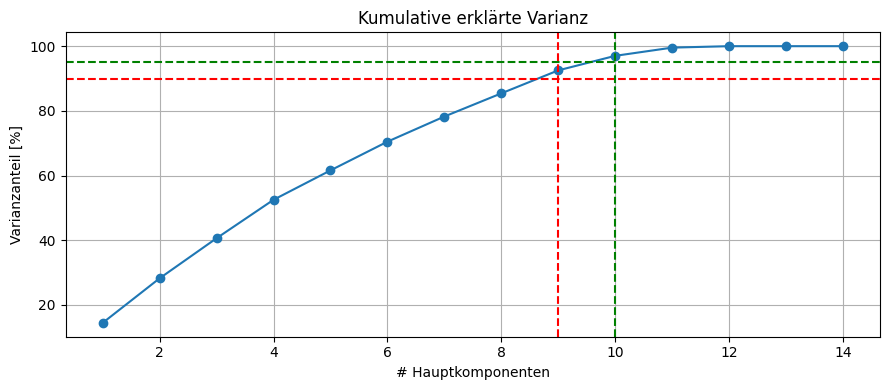


PCA-DataFrame (95 % Varianz):
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.704223 -1.237174 -1.658437  1.251780 -1.394596  0.346860 -0.219022   
1  1.704223 -1.237174 -1.658437  1.251780 -1.394596  0.346860 -0.219022   
2  0.963657  0.971547 -1.395044  1.074701  1.924024 -1.035704 -0.188173   
3  0.963657  0.971547 -1.395044  1.074701  1.924024 -1.035704 -0.188173   
4  1.539916 -1.198632 -1.324761 -1.604098  1.277342 -2.081155 -0.500212   

        PC8       PC9      PC10  
0  1.180233  1.901103  0.719485  
1  1.180233  1.901103  0.719485  
2  2.614018  0.288462  0.745426  
3  2.614018  0.288462  0.745426  
4  0.915486  1.901886  0.693232  


In [59]:
# Feature-Matrix
X = df_Regression.drop(columns=["remainder__fee"])
y = df_Regression["remainder__fee"].astype(int)

# numerische / kategoriale Spalten
num_cols = X.select_dtypes(include=["number"]).columns
cat_cols = X.columns.difference(num_cols)

# Vorverarbeitung
preproc = ColumnTransformer(
    [
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler",  StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe",     OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols)
    ],
    remainder="drop"
)

# PCA
pca = PCA(n_components=None, random_state=42)
pipe = Pipeline([("prep", preproc), ("pca", pca)]).fit(X)

evr     = pipe.named_steps["pca"].explained_variance_ratio_
cum_evr = np.cumsum(evr)
k90 = np.argmax(cum_evr >= 0.90) + 1
k95 = np.argmax(cum_evr >= 0.95) + 1
print(f"90 % Varianz → {k90} Komponenten")
print(f"95 % Varianz → {k95} Komponenten")

# Scree-Plot
plt.figure(figsize=(9, 4))
plt.plot(range(1, len(evr)+1), cum_evr*100, marker="o")
plt.axhline(90, color="red", ls="--");  plt.axvline(k90, color="red", ls="--")
plt.axhline(95, color="green", ls="--"); plt.axvline(k95, color="green", ls="--")
plt.title("Kumulative erklärte Varianz")
plt.xlabel("# Hauptkomponenten"); plt.ylabel("Varianzanteil [%]")
plt.grid(True); plt.tight_layout(); plt.show()

# Transformieren & als DataFrame (95 %)
X_pca  = pipe.transform(X)[:, :k95]
pc_cols = [f"PC{i+1}" for i in range(k95)]
df_Regression_pca  = pd.DataFrame(X_pca, columns=pc_cols, index=X.index)
print("\nPCA-DataFrame (95 % Varianz):")
print(df_Regression_pca.head())


In [60]:
# Feature-Namen nach Preprocessing holen
feat_names = pipe.named_steps["prep"].get_feature_names_out()

# PCA-Komponentenmatrix
components = pipe.named_steps["pca"].components_   # shape: (n_components, n_features)

# DataFrame: Komponenten × Features
loadings = pd.DataFrame(components.T, index=feat_names,
                        columns=[f"PC{i+1}" for i in range(components.shape[0])])

# Für jede Komponente Top-Features ausgeben
top_n = 5  # Anzahl der wichtigsten Features pro Komponente
for pc in loadings.columns[:k95]:   # nur die PCs, die 95 % Varianz erklären
    top_feats = loadings[pc].abs().sort_values(ascending=False).head(top_n)
    print(f"\n{pc} – wichtigste Features:")
    for feat, val in top_feats.items():
        print(f"{feat:40s} | Ladung {val:.3f}")



PC1 – wichtigste Features:
num__remainder__hour_sin                 | Ladung 0.594
num__bin__daytime_Nachmittag             | Ladung 0.530
num__bin__daytime_Nacht                  | Ladung 0.525
num__ord__amount_cat                     | Ladung 0.212
num__remainder__amount_scaled            | Ladung 0.211

PC2 – wichtigste Features:
num__remainder__amount_scaled            | Ladung 0.674
num__ord__amount_cat                     | Ladung 0.673
num__remainder__hour_sin                 | Ladung 0.186
num__bin__daytime_Nachmittag             | Ladung 0.174
num__bin__daytime_Nacht                  | Ladung 0.151

PC3 – wichtigste Features:
num__oh__card_Master                     | Ladung 0.757
num__oh__card_Visa                       | Ladung 0.511
num__oh__card_Diners                     | Ladung 0.402
num__oh__PSP_Simplecard                  | Ladung 0.036
num__bin__daytime_Nachmittag             | Ladung 0.028

PC4 – wichtigste Features:
num__oh__PSP_UK_Card                     | Ladun

In [61]:
top_n = 5  # wie viele Top-Features je PC berücksichtigen

records = []
pcs = loadings.columns[:k95]  # nur PCs bis 95% Varianz

for pc in pcs:
    top_feats = loadings[pc].abs().sort_values(ascending=False).head(top_n)
    for feat, val in top_feats.items():
        records.append({"feature": feat, "pc": pc, "abs_loading": float(val)})

# Aggregation: Summe der Ladungen und Anzahl der Vorkommen je Feature
agg = (pd.DataFrame(records)
         .groupby("feature", as_index=False)
         .agg(sum_abs_loading=("abs_loading", "sum"),
              count=("abs_loading", "size")))

# Optional: max-Ladung und PC der max-Ladung (hilfreich zur Einordnung)
max_info = (pd.DataFrame(records)
              .sort_values(["feature", "abs_loading"], ascending=[True, False])
              .groupby("feature", as_index=False)
              .first()[["feature", "pc", "abs_loading"]]
              .rename(columns={"pc": "pc_max", "abs_loading": "max_abs_loading"}))

result = (agg.merge(max_info, on="feature", how="left")
             .sort_values(["sum_abs_loading", "count"], ascending=[False, False])
             .reset_index(drop=True))

# Ausgabe
print(result.head(20))          # Top 20


                          feature  sum_abs_loading  count pc_max  \
0          num__oh__PSP_Moneycard         1.628568      5    PC6   
1         num__oh__PSP_Simplecard         1.590742      7    PC6   
2            num__bin__3D_secured         1.464230      3    PC8   
3               num__monatsanfang         1.455875      3    PC9   
4            num__oh__card_Diners         1.445963      4    PC5   
5              num__oh__card_Visa         1.414043      4    PC5   
6    num__bin__daytime_Nachmittag         1.411493      4   PC10   
7         num__bin__daytime_Nacht         1.409287      3   PC10   
8           num__oh__PSP_Goldcard         1.251451      5    PC7   
9   num__remainder__amount_scaled         0.918755      3    PC2   
10           num__ord__amount_cat         0.885079      2    PC2   
11           num__oh__PSP_UK_Card         0.858410      3    PC4   
12       num__remainder__hour_sin         0.815315      3    PC1   
13           num__oh__card_Master         0.7569

In [62]:
# 1) Top-Features aus result
selected_features = result["feature"].head(14).tolist()

def strip_prefix(name: str) -> str:
    return re.sub(r'^(num|cat)__', '', name)

orig_names = [strip_prefix(f) for f in selected_features]

# 2) Auf existierende Spalten mappen
present = [c for c in orig_names if c in df_Regression.columns]

# 3) PSP-Spalten und Ziel definieren
psp_candidates = ['oh__PSP_Goldcard', 'oh__PSP_Moneycard',
                  'oh__PSP_Simplecard', 'oh__PSP_UK_Card']
psp_cols = [c for c in psp_candidates if c in df_Regression.columns]
missing_psp = [c for c in psp_candidates if c not in df_Regression.columns]

target = 'remainder__fee'
has_target = target in df_Regression.columns

# 4) Union in stabiler Reihenfolge
def uniq(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

cols_final_pca = uniq(present + psp_cols + ([target] if has_target else []))

# 5) Subset bauen
df_Regression_pca_original_features = df_Regression[cols_final_pca].copy()

print("Gewählte Spalten:", cols_final_pca)
print("Shape:", df_Regression_pca_original_features.shape)

if missing_psp:
    print("Warnung: Fehlende PSP-Spalten:", missing_psp)
if not has_target:
    print(f"Warnung: Zielspalte '{target}' fehlt im DataFrame.")


Gewählte Spalten: ['oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'bin__3D_secured', 'monatsanfang', 'oh__card_Diners', 'oh__card_Visa', 'bin__daytime_Nachmittag', 'bin__daytime_Nacht', 'oh__PSP_Goldcard', 'remainder__amount_scaled', 'ord__amount_cat', 'oh__PSP_UK_Card', 'remainder__hour_sin', 'oh__card_Master', 'remainder__fee']
Shape: (50329, 15)


Die nach PCA und Korrelationsanalyse **zu den wichtigsten gewählten 15 Spalten** bilden einen hochfokussierten Feature-Satz, der die kollektive **PSP- und Kartentyp-Information** mit kritischen **temporalen Hotspots (Nacht/Nachmittag)** und **transaktionsspezifischen Werten (Betrag, Gebühr)** und **§D secured**, sowie **Monatsanfang** und **hour** kombiniert.

In [63]:
#  Vorgaben
target = "remainder__fee"
psp_required = ["oh__PSP_Goldcard", "oh__PSP_Moneycard", "oh__PSP_Simplecard", "oh__PSP_UK_Card"]
k = 5  # Anzahl zu wählender Features je Selektionsmethode

if target not in df_Regression.columns:
    raise ValueError(f"Zielspalte fehlt: {target}")

# X/y und Split
X = df_Regression.drop(columns=[target])
y = df_Regression[target].astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature-Selection Pipelines
pipelines = {
    "KBest (MI)": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("sel", SelectKBest(mutual_info_classif, k=k))
    ]),
    "SFS-GNB": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("sel", SequentialFeatureSelector(
            GaussianNB(), n_features_to_select=k,
            direction="forward", scoring="accuracy", cv=5, n_jobs=-1))
    ]),
    "SFS-DTC": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("sel", SequentialFeatureSelector(
            DecisionTreeClassifier(max_depth=5, random_state=42),
            n_features_to_select=k,
            direction="forward", scoring="accuracy", cv=5, n_jobs=-1))
    ]),
    "RFE-SGD": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("sel", RFE(
            SGDClassifier(loss="log_loss", max_iter=1000, random_state=42),
            n_features_to_select=k, step=0.1))
    ]),
    "RFE-DTC": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("sel", RFE(
            DecisionTreeClassifier(max_depth=5, random_state=42),
            n_features_to_select=k, step=0.1))
    ])
}

# Feature-Selektionen ausführen
selections = {}
for name, pipe in pipelines.items():
    pipe.fit(X_tr, y_tr)
    mask = pipe.named_steps["sel"].get_support()
    feats = [f for f, keep in zip(X.columns, mask) if keep]
    selections[name] = feats
    print(f"\n{name} | {len(feats)} Features")
    print(", ".join(feats))

# Union in Originalspalten-Reihenfolge
def stable_union_in_df_order(df_cols, lists_of_cols):
    seen = set()
    out = []
    for c in df_cols:
        if any(c in L for L in lists_of_cols) and c not in seen:
            seen.add(c)
            out.append(c)
    return out

all_selected_features = stable_union_in_df_order(X.columns, selections.values())
print("\nUnion der gewählten Features:")
print(all_selected_features)

# PSP + Target erzwingen
psp_in_df = [c for c in psp_required if c in df_Classification.columns]
missing_psp = [c for c in psp_required if c not in df_Classification.columns]
if missing_psp:
    print("Warnung: Fehlende PSP-Spalten im DataFrame:", missing_psp)

cols_final_fs = all_selected_features[:]

# PSP-Spalten am Ende in DF-Order ergänzen, falls nicht enthalten
for c in X.columns:  # respektiert Originalreihenfolge
    if c in psp_in_df and c not in cols_final_fs:
        cols_final_fs.append(c)

# Target ergänzen
if target not in cols_final_fs:
    cols_final_fs.append(target)

print("\nGesamtliste inkl. erzwungener PSPs + Target:")
print(cols_final_fs)



KBest (MI) | 5 Features
oh__PSP_Goldcard, oh__PSP_Moneycard, oh__PSP_Simplecard, oh__PSP_UK_Card, remainder__amount_scaled

SFS-GNB | 5 Features
oh__PSP_Goldcard, oh__PSP_Moneycard, oh__card_Diners, oh__card_Master, oh__card_Visa

SFS-DTC | 5 Features
oh__PSP_Goldcard, oh__PSP_Moneycard, oh__PSP_Simplecard, oh__PSP_UK_Card, bin__3D_secured

RFE-SGD | 5 Features
oh__PSP_Goldcard, oh__PSP_Moneycard, oh__PSP_Simplecard, oh__PSP_UK_Card, remainder__amount_scaled

RFE-DTC | 5 Features
oh__PSP_Goldcard, oh__PSP_Simplecard, oh__PSP_UK_Card, bin__3D_secured, remainder__amount_scaled

Union der gewählten Features:
['oh__PSP_Goldcard', 'oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'oh__PSP_UK_Card', 'oh__card_Diners', 'oh__card_Master', 'oh__card_Visa', 'bin__3D_secured', 'remainder__amount_scaled']

Gesamtliste inkl. erzwungener PSPs + Target:
['oh__PSP_Goldcard', 'oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'oh__PSP_UK_Card', 'oh__card_Diners', 'oh__card_Master', 'oh__card_Visa', 'bin__3D_secured'


| Methode | Gewichtung der Features |
| :--- | :--- |
| **KBest (MI), RFE-SGD, RFE-DTC** | Starker Fokus auf die **PSP-Dummies** (alle 4 oder 3) und den **skalierten Betrag** (`remainder__amount_scaled`). Dies bestätigt die Ergebnisse der Korrelationsanalyse, bei der PSP und Betrag als Haupttreiber identifiziert wurden. |
| **SFS-GNB** | Betonung der **PSP-Typen** (`Goldcard`, `Moneycard`) kombiniert mit **allen Kartentypen**, was auf eine starke Verknüpfung der Gebühr mit dem PSP-Karten-Setup hinweist. |
| **SFS-DTC** | Identifiziert fast alle **PSP-Dummies** zusammen mit dem **3D-Secure**-Indikator, was die Rolle der Gebühren bei der Abwicklung von Sicherheitsmerkmalen andeutet. |

### Union der finalen Features


**Gesamtliste der für das Training gewählten Features (inkl. Target):**
`['oh__PSP_Goldcard', 'oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'oh__PSP_UK_Card', 'oh__card_Diners', 'oh__card_Master', 'oh__card_Visa', 'bin__3D_secured', 'remainder__amount_scaled', 'remainder__fee']`

In [64]:
# Alle ausgewählten Features manuell einsammeln
selected_features = cols_final

# Eindeutige Spaltennamen
unique_features = sorted(set(selected_features))

# DataFrame-Kopie nur mit diesen Spalten 
keep_cols = [c for c in unique_features if c in df_Regression.columns]

df_Regression_featureSelection= df_Regression[keep_cols].copy()

print("Shape df_classification_featureSelection:", df_Regression_featureSelection.shape)
print("Spalten in df_classification_featureSelection:", df_Regression_featureSelection.columns.tolist())


Shape df_classification_featureSelection: (50329, 14)
Spalten in df_classification_featureSelection: ['bin__3D_secured', 'bin__daytime_Nachmittag', 'bin__daytime_Nacht', 'monatsanfang', 'oh__PSP_Goldcard', 'oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'oh__PSP_UK_Card', 'oh__card_Diners', 'oh__card_Visa', 'ord__amount_cat', 'remainder__amount_scaled', 'remainder__fee', 'remainder__hour_sin']


In [65]:
combined_features = cols_final_pca + cols_final_fs
selected_features = list(set(combined_features))

# 2. Die Zielvariable ('bin__success') an das Ende verschieben, falls notwendig 
#    (Optional, aber gut für die Übersicht)
TARGET = 'remainder__fee'
if TARGET in selected_features:
    selected_features.remove(TARGET)
    selected_features.append(TARGET)

# Den DataFrame mit der bereinigten Liste erstellen
df_Regression_reduced = df_Regression[selected_features].copy()

print("Anzahl der eindeutigen Spalten:", len(selected_features))
print("Shape df_Selected:", df_Regression_reduced.shape)
print("Spalten in df_Selected:", df_Regression_reduced.columns.tolist())

Anzahl der eindeutigen Spalten: 15
Shape df_Selected: (50329, 15)
Spalten in df_Selected: ['oh__card_Visa', 'oh__PSP_Simplecard', 'oh__card_Master', 'oh__card_Diners', 'monatsanfang', 'bin__daytime_Nachmittag', 'bin__daytime_Nacht', 'ord__amount_cat', 'bin__3D_secured', 'oh__PSP_Moneycard', 'oh__PSP_Goldcard', 'remainder__hour_sin', 'remainder__amount_scaled', 'oh__PSP_UK_Card', 'remainder__fee']


Die nach der Union aller relevanten Feature-Selektionsmethoden für die Regressionsanalyse final gewählten **15 eindeutigen Spalten** bestehen hauptsächlich aus den **PSP- und Kartentypen**, ergänzt durch **Betrags- und Zeitinformationen**, um die **Transaktionsgebühr** (`remainder__fee`) präzise vorhersagen zu können.

In [66]:
print(f"df_Regression ({df_Regression.shape[1]} Spalten): {df_Regression.columns.tolist()}\n")
print(f"df_Regression_pca ({df_Regression_pca.shape[1]} Spalten): {df_Regression_pca.columns.tolist()}\n")
print(f"df_Regression_pca_original_features ({df_Regression_pca_original_features.shape[1]} Spalten): {df_Regression_pca_original_features.columns.tolist()}\n")
print(f"df_Regression_featureSelection ({df_Regression_featureSelection.shape[1]} Spalten): {df_Regression_featureSelection.columns.tolist()}\n")
print(f"df_Regression_reduced ({df_Regression_reduced.shape[1]} Spalten): {df_Regression_reduced.columns.tolist()}\n")


df_Regression (15 Spalten): ['oh__PSP_Goldcard', 'oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'oh__PSP_UK_Card', 'oh__card_Diners', 'oh__card_Master', 'oh__card_Visa', 'bin__3D_secured', 'ord__amount_cat', 'remainder__fee', 'remainder__hour_sin', 'remainder__amount_scaled', 'monatsanfang', 'bin__daytime_Nacht', 'bin__daytime_Nachmittag']

df_Regression_pca (10 Spalten): ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']

df_Regression_pca_original_features (15 Spalten): ['oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'bin__3D_secured', 'monatsanfang', 'oh__card_Diners', 'oh__card_Visa', 'bin__daytime_Nachmittag', 'bin__daytime_Nacht', 'oh__PSP_Goldcard', 'remainder__amount_scaled', 'ord__amount_cat', 'oh__PSP_UK_Card', 'remainder__hour_sin', 'oh__card_Master', 'remainder__fee']

df_Regression_featureSelection (14 Spalten): ['bin__3D_secured', 'bin__daytime_Nachmittag', 'bin__daytime_Nacht', 'monatsanfang', 'oh__PSP_Goldcard', 'oh__PSP_Moneycard', 'oh__PSP_Simplecard', 'o

In [67]:
from pathlib import Path

# aktueller Skriptordner  
this_dir = Path.cwd()                # …/data_preperation
data_dir = (this_dir / ".." / "Data").resolve()
data_dir.mkdir(exist_ok=True)

# Dictionary: Name → DataFrame
dfs = {
    "df_Classification.pkl": df_Classification,
    "df_Classification_pca.pkl": df_Classification_pca,
    "df_classification_pca_original_features.pkl": df_classification_pca_original_features,
    "df_classification_featureSelection.pkl": df_classification_featureSelection,
    "df_classification_reduced.pkl": df_classification_reduced,
    "df_Regression.pkl": df_Regression,
    "df_Regression_pca.pkl": df_Regression_pca,
    "df_Regression_pca_original_features.pkl": df_Regression_pca_original_features,
    "df_Regression_featureSelection.pkl": df_Regression_featureSelection,
    "df_Regression_reduced.pkl": df_Regression_reduced,
}

# Speichern
for fname, df in dfs.items():
    pkl_path = data_dir / fname
    df.to_pickle(pkl_path)
    print(f"{fname} gespeichert in {pkl_path}")


df_Classification.pkl gespeichert in C:\Projects\iu\Model_Engineering\GitPrdner\Data\df_Classification.pkl
df_Classification_pca.pkl gespeichert in C:\Projects\iu\Model_Engineering\GitPrdner\Data\df_Classification_pca.pkl
df_classification_pca_original_features.pkl gespeichert in C:\Projects\iu\Model_Engineering\GitPrdner\Data\df_classification_pca_original_features.pkl
df_classification_featureSelection.pkl gespeichert in C:\Projects\iu\Model_Engineering\GitPrdner\Data\df_classification_featureSelection.pkl
df_classification_reduced.pkl gespeichert in C:\Projects\iu\Model_Engineering\GitPrdner\Data\df_classification_reduced.pkl
df_Regression.pkl gespeichert in C:\Projects\iu\Model_Engineering\GitPrdner\Data\df_Regression.pkl
df_Regression_pca.pkl gespeichert in C:\Projects\iu\Model_Engineering\GitPrdner\Data\df_Regression_pca.pkl
df_Regression_pca_original_features.pkl gespeichert in C:\Projects\iu\Model_Engineering\GitPrdner\Data\df_Regression_pca_original_features.pkl
df_Regression_